The United States Geological Survey's 3-D Elevation Program (3DEP) is collecting high-quality light detection and ranging (lidar) data over the conterminous U.S., Hawaii, and the U.S territories. Data acquisition is ongoing, with over 1800 3DEP datasets consisting of more than 42 trillion points covering an area of greater than 6.5 million $km^{2}$ already available for use. Data are hosted and publically available in Entwine Point Tile (EPT) format in an<a href="https://registry.opendata.aws/usgs-lidar/"> Amazon Web Services (AWS) S3 public bucket</a>.

3DEP point cloud data can be accessed through several user interfaces including the <a href="https://portal.opentopography.org/datasets">OpenTopography Data Portal</a> and the <a href="https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html#/process">USGS Lidar Explorer</a>. In many cases, however, users may prefer to access and produce derivative products from the 3DEP lidar data programmatically, particularly in the case of more advanced users seeking to access and process immense swaths of lidar point cloud data on local, commercial cloud, or high performance compute infrastructure. However, to date tools and/or workflows for programmatic access and processing of the 3DEP data remain underdeveloped.

This Jupyter Notebook is part of a suite developed by OpenTopography in collaboration with the USGS National Geospatial Program, in an effort to leverage available APIs and cloud resources to enhance access and usability of 3DEP data and products for the geospatial community. Importantly, these notebooks are designed to be accessible by user's with limited experience in the Python programming language and as educational tools for those looking to learn about accessing, processing, and visualizing cloud-hosted data with Python. These notebooks use open-source Python libraries, including the Point Data Abstraction Libary (PDAL) and Geospatial Data Abstraction Library (GDAL) for all point cloud and raster processing. 

This and the other use-case specific Jupyter Notebooks developed as part of this effort for programmatic 3DEP access are available in a <a href="https://github.com/OpenTopography/OT_3DEP_Workflows"> Github repository </a> and may be run locally or on the <a href="https://colab.research.google.com/">Google Colaboratory</a> cloud platform.

#### Specific features of this notebook

1. Users may (1) select an area of interest (AOI) directly in an interactive map within this notebook or (2) import a shapefile defining their area of interest.

2. API request to <a href="https://registry.opendata.aws/usgs-lidar/"> Amazon Web Services (AWS) EPT (Entwine Point Tile) S3 bucket</a> returns 3DEP point cloud data within user-defined AOI for subsequent processing. 

3. Flexible and customizable PDAL pipelines are available for specifying point cloud resolution, filtering, reclassifying, and reprojecting points.

4. Option to create a Digital Terrain Model (DTM) or Digital Surface Model (DSM) with user-specifed resolution, gridding method, and file type.

5. Point cloud data and/or derivative products are saved to local directory or on Google Drive (if user uses Google Colaboratory option, see below.)

<a name="Library-Imports"></a>
### Library Imports

After successfully completing the steps outlined in either **Option 1** or **Option 2**, we can now import the modules for use throughout the rest of the notebook.

In [2]:
#Import Modules
import copy
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal
import pdal
import pyproj
import requests
from shapely.geometry import shape, Point, Polygon
from shapely.ops import transform



provide functions for the user to draw area of interest (AOI) on an interactive map and 

- construct the PDAL pipeline for getting the point cloud data from the Amazon Web Services EPT bucket, 
- performing processing steps, 
- producing DEMs, and 
- saving the results. 

A description of the parameters are provided as docstrings in the function definitions.

In [2]:
def proj_to_3857(poly, orig_crs):
    """
    Function for reprojecting a polygon from a shapefile of any CRS to Web Mercator (EPSG: 3857).
    The original polygon must have a CRS assigned.
    
    Parameters:
        poly (shapely polygon): User area of interest (AOI)
        orig_crs (str): the original CRS (EPSG) for the shapefile. It is stripped out during import_shapefile_to_shapely() method

    Returns:
        user_poly_proj4326 (shapely polygon): User AOI in EPSG 4326
        user_poly_proj3857 (shapely polygon): User AOI in EPSG 3857
    """
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project_gcs = pyproj.Transformer.from_crs(orig_crs, wgs84, always_xy=True).transform
    project_wm = pyproj.Transformer.from_crs(orig_crs, web_mercator, always_xy=True).transform
    user_poly_proj4326 = transform(project_gcs, poly)
    user_poly_proj3857 = transform(project_wm, poly)
    return(user_poly_proj4326, user_poly_proj3857)

def gcs_to_proj(poly):
    """
    Function for reprojecting polygon shapely object from geographic coordinates (EPSG:4326) 
    to Web Mercator (EPSG: 3857)). 
    
    Parameters:
        poly (shapely polygon): User area of interest (AOI)

    Returns:
        user_poly_proj3857 (shapely polygon): User AOI in EPSG 3857
    """
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True).transform
    user_poly_proj3857 = transform(project, poly)
    return(user_poly_proj3857)

def import_shapefile_to_shapely(path):
    """
    Conversion of shapefile to shapely object.
    
    Parameters:
        path (filepath): location of shapefile on user's local file system

    Returns:
        user_AOI (shapely polygon): User AOI
    """
    shapefile_path = path
    gdf = gpd.read_file(shapefile_path)
    orig_crs = gdf.crs                   # this is the original CRS of the imported shapefile
    user_shp = gdf.loc[0, 'geometry']
    user_shp_epsg4326, user_shp_epsg3857 = proj_to_3857(user_shp, orig_crs)
    user_AOI = [[user_shp_epsg4326, user_shp_epsg3857]]
    return user_AOI
    
def handle_draw(target, action, geo_json):
    """
    Functionality to draw area of interest (AOI) on interactive ipyleaflet map.
    
    Parameters:
        extent_epsg3857 (shapely polygon): Polygon of user-defined AOI
        usgs_3dep_dataset_name (str): Name of 3DEP dataset which AOI overlaps
        resolution (float): The desired resolution of the pointcloud based on the following definition:
    """
        
    geom = dict(geo_json['geometry'])
    user_poly = shape(geom)
    user_poly_proj3857 = gcs_to_proj(user_poly)
    print('AOI is valid and has boundaries of ', user_poly_proj3857.bounds, 'Please proceed to the next cell.')
    user_AOI.append((user_poly, user_poly_proj3857))  #for various reasons, we need user AOI in GCS and EPSG 3857
    
def downsample_dem(dem):
    """
    Function for evaluating whether DEM should be downsampled prior to plotting. If dem.shape is larger than target.shape, the dem is downsampled.

    Parameters:
        dem (array): 2-D numpy array representing the dem data

    Returns: 
        down_sampled (array): Downsampled 2-D numpy array (if dimensions exceed target dimensions)
        OR
        dem (array): Original 2-D numpy array (if downsampling is not needed)
    """
    target_shape = tuple((1000,1000))   # if either dimension is larger than 1000 pixels, the dem will be downsampled
    scale_factors = [dim_target / dim_input for dim_target, dim_input in zip(target_shape, dem.shape)] 
    
    if any(factor < 1 for factor in scale_factors):
        if scale_factors[0] < 1:
            new_width = dem.rio.width * scale_factors[0]
        else:
            new_width = dem.rio.width
        if scale_factors[1] < 1:
            new_height = dem.rio.height * scale_factors[1]
        else:
            new_height = dem.rio.height

        # Downsample DTM/DSM
        down_sampled = dem.rio.reproject(dem.rio.crs, shape=(int(new_height), int(new_width)), resampling=Resampling.bilinear)
        
        return down_sampled
    
    else:
        return dem
    
def build_pdal_pipeline(extent_epsg3857, usgs_3dep_dataset_names, pc_resolution, filterNoise = False,
                        reclassify = False, savePointCloud = True, outCRS = 3857, pc_outName = 'filter_test', 
                        pc_outType = 'laz'):

    """
    Build pdal pipeline for requesting, processing, and saving point cloud data. Each processing step is a 'stage' 
    in the final pdal pipeline. Each stages is appended to the 'pointcloud_pipeline' object to produce the final pipeline.
    
    Parameters:
    extent_epsg3857 (shapely polygon): Polygon for user-defined AOI in Web Mercator projection (EPS:3857)Polygon is generated 
                            either through the 'handle_draw' methor or by inputing their own shapefile.
    usgs_3dep_dataset_names (str): List of name of the 3DEP dataset(s) that the data will be obtained. This parameter is set 
                                determined through intersecttino of the 3DEP and AOI polys.
    pc_resolution (float): The desired resolution of the pointcloud based on the following definition:
        
                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.
                            
    filterNoise (bool): Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    reclassify (bool): Option to remove USGS classes and run SMRF to classify ground points only. Default == False.
    savePointCloud (bool): Option to save (or not) the point cloud data. If savePointCloud == False, 
           the pc_outName and pc_outType parameters are not used and can be any value.
    outCRS (int): Output coordinate reference systemt (CRS), specified by ESPG code (e.g., 3857 - Web Mercator)
    pc_outName (str): Desired name of file on user's local file system. If savePointcloud = False, 
                  pc_outName can be in value.
    pc_outType (str):  Desired file extension. Input must be either 'las' or 'laz'. If savePointcloud = False, 
                  pc_outName can be in value. If a different file type is requested,the user will get error.
    
    Returns:
        pointcloud_pipeline (dict): Dictionary of processing stages in sequential order that define PDAL pipeline.

    Raises: 
        Exception: If user passes in argument that is not 'las' or 'laz'.
    """
    
    #this is the basic pipeline which only accesses the 3DEP data
    readers = []
    for name in usgs_3dep_dataset_names:
        url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{}/ept.json".format(name)
        reader = {
            "type": "readers.ept",
            "filename": str(url),
            "polygon": str(extent_epsg3857),
            "requests": 3,
            "resolution": pc_resolution
        }
        readers.append(reader)
        
    pointcloud_pipeline = {
            "pipeline":
                readers
    }
    
    if filterNoise == True:
        
        filter_stage = {
            "type":"filters.range",
            "limits":"Classification![7:7], Classification![18:18]"
        }
        
        pointcloud_pipeline['pipeline'].append(filter_stage)
    
    if reclassify == True:
        
        remove_classes_stage = {
            "type":"filters.assign",
            "value":"Classification = 0"
        }
        
        classify_ground_stage = {
            "type":"filters.smrf"
        }
        
        reclass_stage = {
            "type":"filters.range",
            "limits":"Classification[2:2]"
        }

        pointcloud_pipeline['pipeline'].append(remove_classes_stage)
        pointcloud_pipeline['pipeline'].append(classify_ground_stage)
        pointcloud_pipeline['pipeline'].append(reclass_stage)
        
    reprojection_stage = {
        "type":"filters.reprojection",
        "out_srs":"EPSG:{}".format(outCRS)
    }
    
    pointcloud_pipeline['pipeline'].append(reprojection_stage)
    
    if savePointCloud == True:
        
        if pc_outType == 'las':
            savePC_stage = {
                "type": "writers.las",
                "filename": str(pc_outName)+'.'+ str(pc_outType),
            }
        elif pc_outType == 'laz':    
            savePC_stage = {
                "type": "writers.las",
                "compression": "laszip",
                "filename": str(pc_outName)+'.'+ str(pc_outType),
            }
        else:
            raise Exception("pc_outType must be 'las' or 'laz'.")

        pointcloud_pipeline['pipeline'].append(savePC_stage)
        
    return pointcloud_pipeline

def make_DEM_pipeline(extent_epsg3857, usgs_3dep_dataset_name, pc_resolution, dem_resolution,
                      filterNoise = True, reclassify = False, savePointCloud = False, outCRS = 3857,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', 
                      dem_outName = 'dem_test', dem_outExt = 'tif', driver = "GTiff"):
    
    """
    Build pdal pipeline for creating a digital elevation model (DEM) product from the requested point cloud data. The 
    user must specify whether a digital terrain (bare earth) model (DTM) or digital surface model (DSM) will be created, 
    the output DTM/DSM resolution, and the gridding method desired. 

    The `build_pdal_pipeline() method is used to request the data from the Amazon Web Services ept bucket, and the 
    user may define any processing steps (filtering, reclassifying, reprojecting). The user must also specify whether 
    the point cloud should be saved or not. Saving the point cloud is not necessary for the generation of the DEM. 

    Parameters:
        extent_epsg3857 (shapely polygon): User-defined AOI in Web Mercator projection (EPS:3857). Polygon is generated 
                                           either through the 'handle_draw' methor or by inputing their own shapefile.
                                           This parameter is set automatically when the user-defined AOI is chosen.
        usgs_3dep_dataset_names (list): List of name of the 3DEP dataset(s) that the data will be obtained. This parameter is set 
                                        determined through intersecttino of the 3DEP and AOI polys.
        pc_resolution (float): The desired resolution of the pointcloud based on the following definition:

                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.

        pc_outName (str): Desired name of file on user's local file system. If savePointcloud = False, 
                          pc_outName can be in value.
        pc_outType (str): Desired file extension. Input must be either 'las' or 'laz'. If savePointcloud = False, 
                          pc_outName can be in value. If a different file type is requested,the user will get error.
    
        dem_resolution (float): Desired grid size (in meters) for output raster DEM 
        filterNoise (bool): Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
        reclassify (bool): Option to remove USGS classes and run SMRF to classify ground points only. Default == False.
        savePointCloud (bool): Option to save (or not) the point cloud data. If savePointCloud == False, the pc_outName 
                               and pc_outType parameters are not used and can be any value.

        outCRS (int): Output coordinate reference systemt (CRS), specified by ESPG code (e.g., 3857 - Web Mercator)
        pc_outName (str): Desired name of file on user's local file system. If savePointcloud = False, 
                          pc_outName can be in value.
        pc_outType (str): Desired file extension. Input must be either 'las' or 'laz'. If a different file type is requested,
                    the user will get error stating "Extension must be 'las' or 'laz'". If savePointcloud = False, 
                    pc_outName can be in value.
        demType (str): Type of DEM produced. Input must 'dtm' (digital terrain model) or 'dsm' (digital surface model).
        gridMethod (str): Method used. Options are 'min', 'mean', 'max', 'idw'.
        dem_outName (str): Desired name of DEM file on user's local file system.
        dem_outExt (str): DEM file extension. Default is TIF.
        driver (str): File format. Default is GTIFF
    
    Returns:
        dem_pipeline (dict): Dictionary of processing stages in sequential order that define PDAL pipeline.
    Raises: 
        Exception: If user passes in argument that is not 'las' or 'laz'.
        Exception: If user passes in argument that is not 'dtm' or 'dsm'

    """

    dem_pipeline = build_pdal_pipeline(extent_epsg3857, usgs_3dep_dataset_name, pc_resolution,
                                              filterNoise, reclassify, savePointCloud, outCRS, pc_outName, pc_outType)
    
    if demType == 'dsm':
        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    elif demType == 'dtm':
        groundfilter_stage = {
                "type":"filters.range",
                "limits":"Classification[2:2]"
        }

        dem_pipeline['pipeline'].append(groundfilter_stage)

        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    else:
        raise Exception("demType must be 'dsm' or 'dtm'.")
        
    dem_pipeline['pipeline'].append(dem_stage)
    
    return dem_pipeline



3DEP dataset polygon boundaries to check wether 3DEP data is currently available for Inyo County.

 An up-to-date version of usgs-lidar is hosted in the Github repository https://github.com/hobuinc/usgs-lidar/. 

- In the following cell - API request to return boundaries from the repository and save a local copy of these boundaries in geojson format. 
-convert to geopandas dataframe object to easily access the names, url, and point count of each dataset, and we use the ```gcs_to_proj()

function to project each 3DEP polygon geometry to Web Mercator projection (EPSG: 3857), which is the native projection of the 3DEP data in the AWS S3 bucket.

In [3]:
# Get GeoJSON file for 3DEP outlines from URL 

print("Requesting, loading, and projecting 3DEP dataset polygons...")

#request the boundaries from the Github repo and save locally.
url = 'https://raw.githubusercontent.com/hobuinc/usgs-lidar/master/boundaries/resources.geojson'
r = requests.get(url)
with open('resources.geojson', 'w') as f:
    f.write(r.content.decode("utf-8"))

with open('resources.geojson', 'r') as f:
    geojsons_3DEP = json.load(f)
    
#make pandas dataframe and create pandas.Series objects for the names, urls, and number of points for each boundary.
with open('resources.geojson', 'r') as f:
    df = gpd.read_file(f)
    names = df['name']
    urls = df['url']
    num_points = df['count']

#project the boundaries to EPSG 3857 (necessary for API call to AWS for 3DEP data)
projected_geoms = []
for geometry in df['geometry']:
        projected_geoms.append(gcs_to_proj(geometry))

geometries_GCS = df['geometry']
geometries_EPSG3857 = gpd.GeoSeries(projected_geoms)

print('Done. 3DEP polygons downloaded and projected to Web Mercator (EPSG:3857)')

Requesting, loading, and projecting 3DEP dataset polygons...
Done. 3DEP polygons downloaded and projected to Web Mercator (EPSG:3857)


<a name="Create-Interactive-Ipyleaflet-Map-And-Define-AOI"></a>
### Create Interactive Ipyleaflet Map and Define AOI
Next, we will define our area of interest (AOI) using an ipyleaflet interactive map and the 3DEP dataset polygons loaded in the prior step.  There are currently two options for defining the AOI:

1. **Option 1** - User loads their own shapefile (.shp) to define the AOI. If using Google Colab, shapefile should be uploaded to the Google Drive folder or within the runtime in the browser.

- To use **option 1**, In the following cell,  the system path to the .shp should be included between the quotes (e.g., ```shapefile = '/path/to/shapefile.shp'```). The other associated files (.cpg, .dbf., .prj, .shx) must be present within the same folder.  If using Google Colab, the  path should be to the file in the user's Google Drive (i.e., /content/drive/shapefile.shp). If running locally, the path shoudl be to the location of the shapefile on the user's local file system.

2. **Option 2** - User draws a polygon on an ipyleaflet interactive map to define the AOI.

 - To use **option 2**, the path should be left blank (```shapefile = ''```), as it is by default.
 
**The cell must be run either way.**

In [4]:
# Enter shapefile path, if applicable. Example: shapefile_path = '/path/to/shapefile.shp'.
# Otherwise leave as shapefile_path = ''
# Run this cell either way, or next cell will not run appropriately.
shapefile_path = ''

If **option 1** is chosen, running the next cell will load the shapefile and print `shapefile loaded. proceed to next cell`.

If **option 2** is chosen, running the next cell will produce an interactive map, make an ipyleaflet layer out of the 3DEP dataset polygon geojson, and allow the user to draw an AOI. When the map is rendered, use the +/- symbols to zoom in and out. The currently available 3DEP datasets are shown in transparent green polygons. The current functionality of the notebook allows the user AOI to straddle multiple 3DEP datsets. In this case, points from both datasets will be queried and merged into the resulting las/laz file.

**Important Note 1**: Use either the pentagon or rectangle shaped buttons on the left sidebar to define the AOI. The pentagon-shaped button will allow the user to draw a polygon of any shape, and the rectangle-shaped will result in a rectangular AOI. Either shape will work for the boundary parameter in the point cloud request, and either can be used to define the AOI.

**Important Note 2**: If the user would like to draw a new AOI, the cell below must be re-executed each and every time. If multiple AOIs are drawn on the same interactive map without re-executing the cell, subsequent cells will not function appropriately. The cell must be run each and every time the user would like to define a new AOI.

**Important Note 3**: There are currently no checks implemented to keep the user from defining an AOI encompassing billions of lidar points. However, if such an AOI is defined, the compute time and hard drive space required will be substantial. Depending on your personal computer specifications, massive point clouds may cause issues with available RAM. A later cell will provide an estimation of the total point count for the AOI, but it is advisable to keep the AOI ~5000 hectares or less. The area is shown on the interactive map when drawing the AOI.


In [5]:
m = ipyleaflet.Map(
    basemap=ipyleaflet.basemaps.Esri.WorldTopoMap,
    center=(37, -100),
    zoom=3.5,
    crs=ipyleaflet.projections.EPSG3857
    )

geo_json_3DEP = ipyleaflet.GeoJSON(data=geojsons_3DEP, style = {'color': 'green', 'opacity':1, 
                                       'weight':1, 'fillOpacity':0.1})

m.add_layer(geo_json_3DEP)  #add 3DEP polygons GeoJSON

dc = ipyleaflet.DrawControl(
    polygon={"shapeOptions": {"color": "blue"}},
    rectangle={"shapeOptions": {"color": "blue"}},
    circlemarker={},
    polyline={}
)

if os.path.exists(shapefile_path):
    user_AOI = import_shapefile_to_shapely(shapefile_path)
    print('shapefile loaded. proceed to next cell')
    
else:
    print('Select an Area of Interest using the tools on the left side of the map.')
    user_AOI = []
    dc.on_draw(handle_draw)
    m.add_control(dc)
    display(m)

Select an Area of Interest using the tools on the left side of the map.


Map(center=[37, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

AOI is valid and has boundaries of  (-13242436.714922067, 4507706.480910085, -13195953.035151523, 4554180.313901774) Please proceed to the next cell.


<a name="Find-3DEP-Polygon(s)-Intersecting-AOI"></a>
### Find 3DEP Polygon(s) Intersecting AOI
Now that the user-specified AOI is defined, the following cell will determine the intersecting 3DEP dataset names and show the corresponding polygons on an interactive map.  `intersecting_polys` will be a list of the intersecting 3DEP dataset name(s), boundary(ies) in EPSG: 4326, boundary(ies) in EPSG: 3857, url(s), and the number of points in the entire 3DEP dataset(s). The dataset names will be used in the API request to the AWS EPT S3 bucket. A ratio of the total number of points and the area of the user-defined AOI will be used to estimate the total points within the AOI.

In [6]:
AOI_GCS = user_AOI[-1][0]
AOI_EPSG3857 = user_AOI[-1][1]

intersecting_polys = []

for i,geom in enumerate(geometries_EPSG3857):
    if geom.intersects(AOI_EPSG3857):
        intersecting_polys.append((names[i], geometries_GCS[i], geometries_EPSG3857[i], urls[i], num_points[i]))
        
print(intersecting_polys)

[('USGS_LPC_CA_LongValleyCaldera_2017_LAS_2018', <MULTIPOLYGON (((-118.812 37.561, -118.735 37.543, -118.717 37.555, -118.668...>, <MULTIPOLYGON (((-13226066 4517647.1, -13217566 4515049, -13215566 4516781.1...>, 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/USGS_LPC_CA_LongValleyCaldera_2017_LAS_2018/ept.json', 1542355109)]


<a name="Specify-Point-Cloud-Resolution"></a>
### Specify Point Cloud Resolution
Executing the next cell will show the AOI, the relevant 3DEP dataset(s) on another interactive map, and the option to specify point cloud resolution. 

Importantly, after the map is rendered, the user must define the desired 'point cloud resolution' using the radio buttons below the map. An estimation of the total number of lidar points within the bounding box is provided based on the area of the AOI and the total number of lidar points in the 3DEP dataset(s). Selecting the "Full" option will return all points in the quad (this number can be quite large, depending on the size of the AOI). Selecting any of the other options for resolution will return the appropriate number of points to ensure at least one lidar point per Nth meter (where N is the chosen resolution). The Entwine Point Tile (EPT) file format utilizes an octree structure for the point cloud, and the chosen resolution defines how deep in the octree to request points to obtain the specified resolution. This depth, and total number points varies drastically based on a number of parameters including local topography and vegetation. Therefore, the 'resolution' paramater and the total point count do not scale linearly. In other words, specifying a resolution of 2m will likely return far less than half of the number of points returned with 'full' resolution. The estimate of the full poin total provided is not exact, but should give the user some idea of how many points to expect the resultant point cloud to contain. 

Select the appropriate radio button below the map to specify `pointcloud_resolution`.

In [7]:
# Find AOI center for plotting purposes
centroid =  list(AOI_GCS.centroid.coords)[0]

#make ipyleaflet map
m = ipyleaflet.Map(
    basemap=ipyleaflet.basemaps.Esri.WorldTopoMap,
    center=(centroid[1],centroid[0]),
    zoom=12,
    )

#add intersecting 3DEP polygon(s) to the map
wlayer_3DEP_list = []
usgs_3dep_datasets = []
number_pts_est = []
for i, poly in enumerate(intersecting_polys):
    wlayer_3DEP = ipyleaflet.WKTLayer(
        wkt_string=poly[1].wkt, 
        style={"color": "green"})
    
    m.add_layer(wlayer_3DEP)
    wlayer_3DEP_list.append(wlayer_3DEP)
    usgs_3dep_datasets.append(poly[0])
    
    #estimate total points using ratio of area and point count
    number_pts_est.append((int((AOI_EPSG3857.area/poly[2].area)*(poly[4]))))


#make ipyleaflet layers from the AOI and add to map
wlayer_user = ipyleaflet.WKTLayer(
    wkt_string=AOI_GCS.boundary.wkt,
    style={"color": "blue"}
)

AOI_EPSG3857_wkt = AOI_EPSG3857.wkt
m.add_layer(wlayer_user)


#sum the estimates of the number of points from each 3DEP dataset within the AOI
num_pts_est = sum(number_pts_est)

#Plot map and specify desired point cloud resolution using a widget
user_resolution = widgets.RadioButtons(
    options=[
        (f'Full - All ~{int(math.ceil(num_pts_est/1e6)*1e6):,} points', 1.0),
        (f'High - 2m resolution', 2.0),
        (f'Mid  - 5m resolution', 5.0),
        (f'Low  - 10m resolution', 10.0)
    ],
    layout={'width': 'max-content'},
    disabled = False,
)

display(m)
print(f'Your AOI at full resolution will include approximately {int(math.ceil(num_pts_est/1e6)*1e6):,} points. Select desired point cloud resolution.')
widgets.VBox(
    [user_resolution]
)

Map(center=[37.6558155, -118.750048], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Your AOI at full resolution will include approximately 4,692,000,000 points. Select desired point cloud resolution.


<font color='red'>**Note**: Lidar point clouds can get *very* large, *very* fast, and the point counts provided above are an estimate. Selecting the `Full` or `High` option when using Google Colaboratory (12GB RAM allocation) may cause the runtime to fail when attempting to access data exceeding ~50-100 million points. If full resolution is desired, we recommend running this notebook locally on hardware with more RAM. Keep this in mind when deciding the AOI size and point cloud resolution above!</font>

The AOI bounding box, the relevant 3DEP dataset name(s), and the desired point cloud resolution are now defined. We can proceed with the API request to the AWS EPT bucket, processing, visualizing, and saving the data.

<a name="Construct-and-Exectute-PDAL-Pipeline-for-Point-Cloud-Data"></a>
### Construct and Exectute PDAL Pipeline for Point Cloud Data
The Point Data Abstraction Library (PDAL) is an open-source tool for translating and manipulating point cloud data. PDAL pipelines are useful ways of processing and manipulating point cloud data and creating derivative products. Pipelines comprise one or more stages that are read and executed in order on the point cloud dataset(s). 

The PDAL pipeline is constructed using the ```build_pdal_pipeline()``` function, and will construct the appropriate pipeline for the user's specifications (defined as function arguments). Executing this pipeline will make the API request, perform processing on the point cloud data (chosen by user) and provide the final result on the user's file system of Google Drive (Google Colab).  

Paramaters (for more detailed descriptions of parameters, see <a href="#Define-Functions" data-toc-modified-id="Define-Functions-6.3">the function definitions</a>, above: <br>
```AOI_EPSG3857_wkt```: the user-defined area of interest (AOI)<br>
```usgs_3dep_datasets```: the intersecting 3DEP dataset names<br>
```pointcloud_resolution```: point cloud resolution (1m, 2m, 5m, 10m)<br>
```filterNoise```: remove the points of Class 7 (low noise) and Class 18 (high noise);<br>
```reclassify```: remove USGS classes and run an SMRF to classify ground points only<br>
```savePointCloud```: specify if point cloud data should be saved to local file system<br>
```outCRS```: specify the coordinate reference system (CRS, in EPSG) of the output dataset.<br>
```pc_outName```: name of point cloud on local file system<br>
```pc_outType```: file type, las or laz (laszip compression). Options are 'las' or 'laz'<br>

**Important Note 1: The ```AOI_EPSG3857_wkt```, ```usgs_3dep_datasets```, and ```pointcloud_resolution``` arguments are already defined. These should not be modified.**

In [25]:
# Do not modify AOI_EPSG3857_wkt, usgs_3dep_datasets, or pointcloud_resolution
# Modify the optional arguments to fit user need.
# Change outCRS to EPSG code of desired coordinate reference system (Default is EPSG:3857 - Web Mercator Projection)
# Change pc_outname to descriptive name and pc_outType to 'las' or 'laz'.

pointcloud_resolution = user_resolution.value
pc_pipeline = build_pdal_pipeline(AOI_EPSG3857_wkt, usgs_3dep_datasets, pointcloud_resolution, filterNoise = True,
                                  reclassify = False, savePointCloud = True, outCRS = 3857, 
                                  pc_outName = 'pointcloud_test', pc_outType = 'laz')

The PDAL pipeline is now constructed. Running the the PDAL Python bindings function ```pdal.Pipeline()``` creates the pdal.Pipeline object from a json-ized version of the pointcloud pipeline we created.

In [26]:
pc_pipeline = pdal.Pipeline(json.dumps(pc_pipeline))

The cell below will execute the pc_pipeline object, which will make the API request, performing processing, and save the point cloud (if `savePointCloud == True`) at the specified location, name, and extension.

Executing the pipeline in streaming mode will speed up the process and cuts down on the required RAM. The `%%time` magic command will return the total computation time. The final output is the total number of points returned.

**Note**: If `reclassify == True` in the pipeline constructed above, a step is added for removing assigned USGS classifications and running a SMRF filter to classify ground points only. When `reclassify == True`, the PDAL pipeline cannot be executed in streaming mode, as reclassification requires all points to be present in memory. **<font color='red'>Be aware that this will be slower than executing in streaming mode and may not be possible for very large point clouds due to RAM limitations.</font>** Commands for executing the pipeline in streaming and non-streaming mode are included below. Comment/uncomment the appropriate command below (depending on whether `reclassify == True` or `reclassify == False` in the pipeline constructed above).

In [27]:
%%time
pc_pipeline.execute_streaming(chunk_size=1000000) # use this if reclassify == False 
#pc_pipeline.execute() # use this if reclassify == True 

CPU times: total: 13min 50s
Wall time: 18min 1s


278679733

If the user only desires point cloud data, they may stop here. Following is an overview on how a DSM and DTM may be created.

<a name="Digital-Elevation-Model-(DEM)-Generation"></a>
### Digital Elevation Model (DEM) Generation 
The following cells may be run to produce a DSM and DTM of the user-defined AOI. The DTM is produced using only points classified as 'Ground' (USGS Class 2), and therefore, represents the surface of the ground beneath any vegetation. Alternatively, a DSM uses all points to produce a representation of the surface including vegetation and other structures. 

The DTM/DSM is produced using an analogous approach to point cloud request and processsing. Namely, a PDAL pipeline is constructed using the function `make_DEM_pipeline()`. This function first constructs a pipeline using `build_pdal_pipeline()` to create stages related to point cloud access and processing. The function then appends PDAL stages specific to the creation of gridded products that fit the specification of the user (defined as function arguments), namely dem resolution and dem type.

Paramaters (for more detailed descriptions of parameters, see <a href="#Define-Functions" data-toc-modified-id="Define-Functions-6.3">the function definitions</a>, above:<br>
`AOI_EPSG3857_wkt`: the user-defined area of interest (AOI)<br>
`usgs_3dep_dataset`: the corresponding 3DEP dataset name<br>
`pointcloud_resolution`: point cloud resolution (1m, 2m, 5m, 10m)<br>
`dem_generation`: grid size for dem product (specified in meters)<br>
`filterNoise`: remove the points of Class 7 (noise); optional<br>
`reclassify`: remove USGS classes and run an SMRF to classify ground points only<br>
`savePointCloud`: specify if point cloud data should be saved to local file system<br>
`pc_outName`: name of point cloud on local file system<br>
`pc_outType`: file type, las or laz (laszip compression). Options are 'las' or 'laz'<br>
`demType`: specifies to create digital surface model (DSM) or digital terrain model (DTM)<br>
`gridMethod`: gridding method to use; options: (min, mean, max, idw)<br>
`dem_outName`: name of dem on local file system <br>
`dem_outExt`: extension of file on local file system (must correspond to what is chosen for ```driver```<br>
`driver`: gdal code of the driver (default is "GTiff"; other options can be found at https://gdal.org/drivers/raster/index.html<br>


**Important note 1: The `make_DEM_pipeline()` function is used for the making of both DSM and DTM products. The type of DEM (DSM/DTM) is specified in the `demType` argument (e.g., `demType = 'dsm'`)**

**Important Note 2: The `AOI_EPSG3857_wkt`, `usgs_3dep_datasets`, and `pointcloud_resolution` arguments are already defined after running the above cells. These should not be modified.**

<a name="Make-Digital-Surface-Model-(DSM)"></a>
### Make Digital Surface Model (DSM)
The following cells will produce a Digital Surface Model (DSM) using all of the lidar returns in the point cloud.
Do not modify the `AOI_EPSG3857_wkt`, `usgs_3dep_datasets`, or `pointcloud_resolution` arguments. Specify the desired dsm resolution (in meters), the appropriate point cloud processing steps, and the file names/extensions.

In [11]:
# Do not modify AOI_EPSG3857_wkt, usgs_3dep_datasets, or pointcloud_resolution
# Modify the optional arguments to fit user need.
# Change outCRS to EPSG code of desired coordinate reference system (Default is EPSG:3857 - Web Mercator Projection)
# Change dem_outName to descriptive name; dem_outExt can be any extension supported by gdal.

pointcloud_resolution = user_resolution.value
dsm_resolution = 2.0
dsm_pipeline = make_DEM_pipeline(AOI_EPSG3857_wkt, usgs_3dep_datasets, pointcloud_resolution, dsm_resolution,
                                 filterNoise = True, reclassify = False,  savePointCloud = False, outCRS = 32613,
                                 pc_outName = 'pointcloud_test', pc_outType = 'laz', demType = 'dsm', 
                                 gridMethod='idw', dem_outName = 'test_dsm', dem_outExt = 'tif', driver = "GTiff")

The PDAL pipeline is now constructed for making the DSM. Running the the PDAL Python bindings function ```pdal.Pipeline()``` creates the pdal.Pipeline object from a json-ized version of the pointcloud pipeline we created.

In [12]:
dsm_pipeline = pdal.Pipeline(json.dumps(dsm_pipeline))

The cell below will execute the dsm_pipeline object, which will make the API request, performing processing, and save the point cloud (if `savePointCloud == True`) and create and save the DSM at the specified location, name, and extension. 

Executing the pipeline in streaming mode will speed up the process and cuts down on the required RAM. The `%%time` magic command will return the total computation time. The final output is the total number of points returned.

**Note**: If `reclassify == True` in the pipeline constructed above, a step is added for removing assigned USGS classifications and running a SMRF filter to classify ground points only. When `reclassify == True`, the PDAL pipeline cannot be executed in streaming mode, as reclassification requires all points to be present in memory. **<font color='red'>Be aware that this will be slower than executing in streaming mode and may not be possible for very large point clouds due to RAM limitations.</font>** Commands for executing the pipeline in streaming and non-streaming mode are included below. Comment/uncomment the appropriate command below (depending on whether `reclassify == True` or `reclassify == False` in the pipeline constructed above).

In [13]:
%%time
dsm_pipeline.execute_streaming(chunk_size=1000000) # use this if reclassify == False
#dsm_pipeline.execute() # use this if reclassify == True  

CPU times: total: 11min 18s
Wall time: 11min 29s


17241662

Below, the same process is outlined for the making of at DTM. 

<a name="Make-Digital-Terrain-Model-(DTM)"></a>
### Make Digital Terrain Model (DTM)
The following cells will produce a Digital Terrain Model (DTM), also called a 'bare earth model' using lidar returns classified as 'ground' (USGS Class 2). Do not modify the `AOI_EPSG3857_wkt`, `usgs_3dep_datasets`, or `pointcloud_resolution` arguments. Specify the desired dtm resolution (in meters), the appropriate point cloud processing steps, and the file names/extensions.

In [14]:
# Do not modify AOI_EPSG3857_wkt, usgs_3dep_datasets, or pointcloud_resolution
# Modify the optional arguments to fit user need.
# Change outCRS to EPSG code of desired coordinate reference system (Default is EPSG:3857 - Web Mercator Projection)
# Change dem_outname to descriptive name and change dem_outExt and driver to desired file type.

pointcloud_resolution = user_resolution.value
dtm_resolution = 2.0
dtm_pipeline = make_DEM_pipeline(AOI_EPSG3857_wkt, usgs_3dep_datasets, pointcloud_resolution, dtm_resolution,
                                 filterNoise = True, reclassify = False, savePointCloud = False, outCRS = 3857,
                                 pc_outName = 'pointcloud_test', pc_outType = 'laz', demType = 'dtm', 
                                 gridMethod='idw', dem_outName = 'test_dtm', dem_outExt = 'tif', driver = "GTiff")

The PDAL pipeline is now constructed for making the DTM. Running the the PDAL Python bindings function ```pdal.Pipeline()``` creates the pdal.Pipeline object from a json-ized version of the pointcloud pipeline we created.

In [15]:
dtm_pipeline = pdal.Pipeline(json.dumps(dtm_pipeline))

The cell below will execute the dtm_pipeline object, which will make the API request, performing processing, and save the point cloud (if `savePointCloud == True`) and create and save the DTM at the specified location, name, and extension. 

Executing the pipeline in streaming mode will speed up the process and cuts down on the required RAM. The `%%time` magic command will return the total computation time. The final output is the total number of points returned.

**Note**: If `reclassify == True` in the pipeline constructed above, a step is added for removing assigned USGS classifications and running a SMRF filter to classify ground points only. When `reclassify == True`, the PDAL pipeline cannot be executed in streaming mode, as reclassification requires all points to be present in memory. **<font color='red'>Be aware that this will be slower than executing in streaming mode and may not be possible for very large point clouds due to RAM limitations.</font>** Commands for executing the pipeline in streaming and non-streaming mode are included below. Comment/uncomment the appropriate command below (depending on whether `reclassify == True` or `reclassify == False` in the pipeline constructed above).

In [16]:
%%time
dtm_pipeline.execute_streaming(chunk_size=1000000) # use this if reclassify == False 
#dtm_pipeline.execute() # use this if reclassify == True

CPU times: total: 5min 23s
Wall time: 6min 15s


9465659

<a name="Visualize-DEMs-(DSM/DTM)"></a>
## Visualize the DEM (DSM/DTM)
We can now visualize the DSM or DTM products in the Jupyter Notebook. We use the <a href="https://corteva.github.io/rioxarray/stable/"> rioxarray </a> and <a href="https://matplotlib.org/stable/users/index.html"> matplotlib </a> Python libraries for simple plotting. We import `rioxarray` and `matplotlib.pyplot` here.

In [28]:
import rioxarray as rio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

Now we must define the file name we would like to plot. This could be a file path (e.g., `/path/to/my/dtm/dtm.tif`). Then we open the dtm as an `xarray` object.

In [29]:
dtm_name = 'test_dtm.tif' # /path/to/your/dtm/dtm.tif
dtm = rio.open_rasterio(dtm_name, masked=True).squeeze()

DEMs can be very large and require significant RAM to plot. Here, we apply a downsampling technique for more efficient visualization. DSM for Crowley lake area is 385mb and the DTM is 220mb

In [19]:
dtm = downsample_dem(dtm)

Now we plot the DTM. By default, we use the 'viridis' colorbar to plot the bare earth elevation. Other colormaps can be used, and more information about available colormaps can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html ).

Using the argument `robust=True` stretches the colors between the 2nd and 98th percentiles of our elevation data. This is just for visualization - the original values are preserved.

In [1]:
plt.figure(figsize=(10,10))
dtm.plot(cmap="viridis", robust=True)
plt.title("Digital Terrain Model (DTM) in Meters")
plt.ticklabel_format(style="plain")
plt.axis('equal')

NameError: name 'plt' is not defined

Crowley Lake is one of the only 3DEP lidar available in the region. 

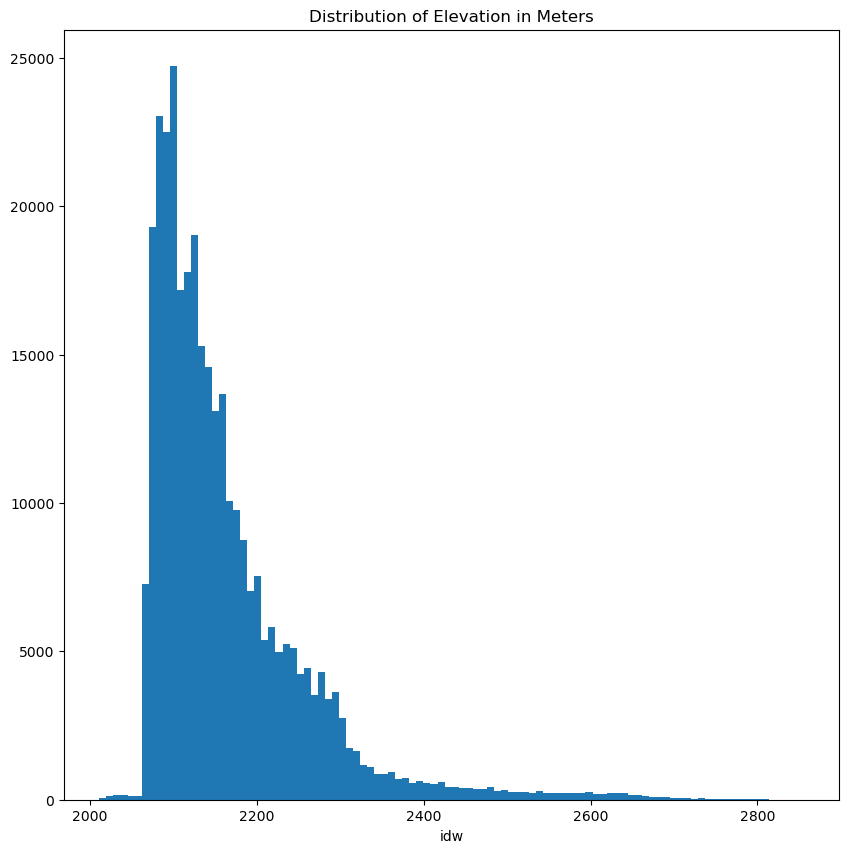

In [21]:
plt.figure(figsize=(10,10))
dtm.plot.hist(bins=100)
plt.title("Distribution of Elevation in Meters");

<a name="Conclusion"></a>
## Conclusion
This Jupyter Notebook is designed to make accessing, processing, visualizing, and creating derivative products with 3DEP more straightforward. Specifically, this notebook provides a workflow for programmatically accessing the 3DEP lidar point cloud data using an API request to the cloud-hosted AWS S3 bucket, performing basic processing steps on the point cloud data, and producing digital elevation models (DTMs/DSMs) for a region specified by the user. 



## Citation

To cite this notebook:  Speed, C., Beckley, M., Crosby, C., & Nandigam, V. (2022). Generate and visualize DEMs (DTM and DSM) from USGS 3D Elevation Program (3DEP) lidar data for user-defined area of interest (Version v1.0). DOI: Accessed: 06/11/2024. 

Customized: 06/12/2024. Inyo County Water Department. (2024). DTM and DSM from lidar data for Crowley Lake Area, delta and outflow.